In [1]:
## task06

# 1.自定义损失函数

In [19]:
import torch
import torch.nn as nn
import numpy as np

## 函数

In [3]:
def my_loss(output, target):
    loss = torch.mean((output - target)**2)
    return loss


## 类

### MSE

In [16]:
class My_loss(nn.Module):
    def __init__(self):
        super().__init__()   #没有需要保存的参数和状态信息
        
    def forward(self, x, y):  # 定义前向的函数运算即可
        return torch.mean(torch.pow((x - y), 2))


### DiceLoss

In [17]:
class DiceLoss(nn.Module):
    def __init__(self,weight=None,size_average=True):
        super(DiceLoss,self).__init__()
        
    def forward(self,inputs,targets,smooth=1):
        inputs = F.sigmoid(inputs)       
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()                   
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        return 1 - dice

# 使用方法    
# criterion = DiceLoss()
# loss = criterion(input,targets)

loss函数：BCE-Dice Loss，Jaccard/Intersection over Union (IoU) Loss，Focal Loss......

### DiceBCELoss

In [20]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = F.sigmoid(inputs)       
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()                     
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

### IoULoss

In [21]:
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = F.sigmoid(inputs)       
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return 1 - IoU

### FocalLoss

In [24]:
ALPHA = 0.8
GAMMA = 2

class FocalLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalLoss, self).__init__()

    def forward(self, inputs, targets, alpha=ALPHA, gamma=GAMMA, smooth=1):
        inputs = F.sigmoid(inputs)       
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1-BCE_EXP)**gamma * BCE
                       
        return focal_loss

## 测试

In [25]:
# step1:自定义损失函数
# step2:准备数据集
# 准备数据集，模拟一个线性拟合过程
x_train = np.array([[3.3], [4.4], [5.5], [6.71], [6.93], [4.168], 
                    [9.779], [6.182], [7.59], [2.167], [7.042], 
                    [10.791], [5.313], [7.997], [3.1]], dtype=np.float32)
 
y_train = np.array([[1.7], [2.76], [2.09], [3.19], [1.694], [1.573], 
                    [3.366], [2.596], [2.53], [1.221], [2.827], 
                    [3.465], [1.65], [2.904], [1.3]], dtype=np.float32)
 
# 将numpy数据转化为torch的张量
inputs = torch.from_numpy(x_train)
targets = torch.from_numpy(y_train)

In [26]:
# step3:构建模型
input_size = 1
output_size = 1
num_epochs = 60
learning_rate = 0.001
 
# 构建模型，构建一个一层的网络模型
model = nn.Linear(input_size, output_size)
 
# 与模型相关的配置、损失函数、优化方式
# 使用自定义函数，等价于criterion = nn.MSELoss()
criterion = My_loss()  #IoULoss
 
# 定义迭代优化算法， 使用的是随机梯度下降算法
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

In [27]:
# step4：训练模型
loss_history = []
# 训练模型，迭代训练
for epoch in range(num_epochs):
    #  前向传播计算网络结构的输出结果
    outputs = model(inputs)
 
    # 计算损失函数
    loss = criterion(outputs, targets)
    
    # 反向传播更新参数，三步策略，归零梯度——>反向传播——>更新参数
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
 
    # 打印训练信息和保存loss
    loss_history.append(loss.item()) 
    if (epoch+1) % 5 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

Epoch [5/60], Loss: 7.1327
Epoch [10/60], Loss: 3.0103
Epoch [15/60], Loss: 1.3402
Epoch [20/60], Loss: 0.6636
Epoch [25/60], Loss: 0.3894
Epoch [30/60], Loss: 0.2783
Epoch [35/60], Loss: 0.2332
Epoch [40/60], Loss: 0.2149
Epoch [45/60], Loss: 0.2075
Epoch [50/60], Loss: 0.2044
Epoch [55/60], Loss: 0.2031
Epoch [60/60], Loss: 0.2025


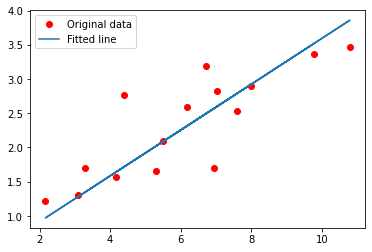

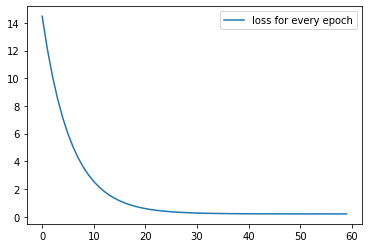

In [29]:
# step5：结果展示。画出原y与x的曲线与网络结构拟合后的曲线
import matplotlib.pyplot as plt

predicted = model(torch.from_numpy(x_train)).detach().numpy() #模型输出结果
 
plt.plot(x_train, y_train, 'ro', label='Original data')       #原始数据
plt.plot(x_train, predicted, label='Fitted line')             #拟合之后的直线
plt.legend()
plt.show()
 
# 画loss在迭代过程中的变化情况
plt.plot(loss_history, label='loss for every epoch')
plt.legend()
plt.show()

# 2.动态调整学习率

通过一个适当的学习率衰减策略来改善这种现象，提高我们的精度

## 使用官方scheduler

### 简介&使用

torch.optim.lr_scheduler 封装了一些动态调整学习率的方法：
https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler
- lr_scheduler.LambdaLR
- lr_scheduler.MultiplicativeLR
- lr_scheduler.StepLR
- lr_scheduler.MultiStepLR
- lr_scheduler.ExponentialLR
- lr_scheduler.CosineAnnealingLR
- lr_scheduler.ReduceLROnPlateau
- lr_scheduler.CyclicLR
- lr_scheduler.OneCycleLR
- lr_scheduler.CosineAnnealingWarmRestarts

选择一种优化器
optimizer = torch.optim.Adam(...) \n

选择上面提到的一种或多种动态调整学习率的方法

scheduler1 = torch.optim.lr_scheduler 

scheduler2 = torch.optim.lr_scheduler
...

schedulern = torch.optim.lr_scheduler

进行训练
for epoch in range(100):
    train(...)
    validate(...)
    optimizer.step()
    # 需要在优化器参数更新之后再动态调整学习率
    scheduler1.step() 
    ...
    schedulern.step()

## 自定义scheduler

通过自定义函数`adjust_learning_rate`来改变`param_group`中`lr`的值

In [ ]:
def adjust_learning_rate(optimizer, epoch):
    lr = args.lr * (0.1 ** (epoch // 30))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
        
#调用
optimizer = torch.optim.SGD(model.parameters(),lr = args.lr,momentum = 0.9)
for epoch in range(10):
    train(...)
    validate(...)
    adjust_learning_rate(optimizer,epoch)

# 3.模型微调

原因：适用于大数据集的开源模型如果直接应用于实际中，可能会出现过拟合的情况，借助迁移学习的方法，进行模型微调。

## 流程

## 使用已有模型结构

### 实例化网络

In [34]:
import torchvision.models as models
resnet18 = models.resnet18()
# resnet18 = models.resnet18(pretrained=False)  等价于与上面的表达式
alexnet = models.alexnet()
vgg16 = models.vgg16()
squeezenet = models.squeezenet1_0()
densenet = models.densenet161()
inception = models.inception_v3()
googlenet = models.googlenet()
shufflenet = models.shufflenet_v2_x1_0()
mobilenet_v2 = models.mobilenet_v2()
mobilenet_v3_large = models.mobilenet_v3_large()
mobilenet_v3_small = models.mobilenet_v3_small()
resnext50_32x4d = models.resnext50_32x4d()
wide_resnet50_2 = models.wide_resnet50_2()
mnasnet = models.mnasnet1_0()

D:\software\anaconda\lib\site-packages\torchvision\models\inception.py:44: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(
D:\software\anaconda\lib\site-packages\torchvision\models\googlenet.py:46: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


### 传递`pretrained`参数

通过`True`或者`False`来决定是否使用预训练好的权重，在默认状态下`pretrained = False`，意味着我们不使用预训练得到的权重，当`pretrained = True`，意味着我们将使用在一些数据集上预训练得到的权重。

In [ ]:
import torchvision.models as models
resnet18 = models.resnet18(pretrained=True)
alexnet = models.alexnet(pretrained=True)
squeezenet = models.squeezenet1_0(pretrained=True)
vgg16 = models.vgg16(pretrained=True)
densenet = models.densenet161(pretrained=True)
inception = models.inception_v3(pretrained=True)
googlenet = models.googlenet(pretrained=True)
shufflenet = models.shufflenet_v2_x1_0(pretrained=True)
mobilenet_v2 = models.mobilenet_v2(pretrained=True)
mobilenet_v3_large = models.mobilenet_v3_large(pretrained=True)
mobilenet_v3_small = models.mobilenet_v3_small(pretrained=True)
resnext50_32x4d = models.resnext50_32x4d(pretrained=True)
wide_resnet50_2 = models.wide_resnet50_2(pretrained=True)
mnasnet = models.mnasnet1_0(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Administrator/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\Administrator/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

**注意事项：**
1. 通常PyTorch模型的扩展为`.pt`或`.pth`，程序运行时会首先检查默认路径中是否有已经下载的模型权重，一旦权重被下载，下次加载就不需要下载了。
2. 一般情况下预训练模型的下载会比较慢，我们可以直接通过迅雷或者其他方式去 [这里](https://github.com/pytorch/vision/tree/master/torchvision/models) 查看自己的模型里面`model_urls`，然后手动下载，预训练模型的权重在`Linux`和`Mac`的默认下载路径是用户根目录下的`.cache`文件夹。在`Windows`下就是`C:\Users\<username>\.cache\torch\hub\checkpoint`。我们可以通过使用 [`torch.utils.model_zoo.load_url()`](https://pytorch.org/docs/stable/model_zoo.html#torch.utils.model_zoo.load_url)设置权重的下载地址。
3. 如果觉得麻烦，还可以将自己的权重下载下来放到同文件夹下，然后再将参数加载网络。
4.如果中途强行停止下载的话，一定要去对应路径下将权重文件删除干净，要不然可能会报错

In [ ]:
self.model = models.resnet50(pretrained=False)
self.model.load_state_dict(torch.load('./model/resnet50-19c8e357.pth'))

## 训练特定层

当提取特征并且为新初始化的层计算梯度，其他参数不进行改变。则需要通过设置`requires_grad = False`来冻结部分层

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
#`resnet18`为例

In [ ]:
import torchvision.models as models
# 冻结参数的梯度
feature_extract = True
model = models.resnet18(pretrained=True)
set_parameter_requires_grad(model, feature_extract)
# 修改模型
num_ftrs = model.fc.in_features
model.fc = nn.Linear(in_features=512, out_features=4, bias=True)

# 4.半精度训练

GPU的性能主要分为两部分：算力和显存，前者决定了显卡计算的速度，后者则决定了显卡可以同时放入多少数据用于计算。如何合理使用显存在训练中十分重要。

## 半精度训练的设置

- **import autocast**：from torch.cuda.amp import autocast
- **模型设置**
@autocast()   
def forward(self, x):
    ...
    return x
- **训练过程**

In [ ]:
 for x in train_loader:
    x = x.cuda()
    with autocast():
        output = model(x)
        ...